In [ ]:
# %load_ext autoreload
# %autoreload 2

In [1]:
from platform import *
machine(), version(), platform(), uname(), system(), processor()

('AMD64',
 '10.0.19044',
 'Windows-10-10.0.19044-SP0',
 uname_result(system='Windows', node='LAPTOP-CVSBCQVV', release='10', version='10.0.19044', machine='AMD64', processor='Intel64 Family 6 Model 140 Stepping 1, GenuineIntel'),
 'Windows',
 'Intel64 Family 6 Model 140 Stepping 1, GenuineIntel')

In [20]:
from vids import Video, preview, Timer
from tqdm import tqdm
import numpy as np
import dask.array as da
from dask import delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from time import process_time
from os.path import getsize
import seaborn as sns

In [3]:

vid = Video('jwasp0.avi')
frame = vid[9]
frame.shape

(1080, 1440, 3)

### Does seeking backward take longer than seeking forward?



{10: 0.0692913}
{10: 0.0692913, 30: 0.330012}
{10: 0.0692913, 30: 0.330012, 90: 1.2544951}
{10: 0.0692913, 30: 0.330012, 90: 1.2544951, 270: 4.1785848}
{10: 0.0692913, 30: 0.330012, 90: 1.2544951, 270: 4.1785848, 490: 7.9962463}
{10: 0.0692913, 30: 0.330012, 90: 1.2544951, 270: 4.1785848, 490: 7.9962463, 710: 12.0135786}
{10: 0.0810665}
{10: 0.0810665, 30: 0.39492910000000003}
{10: 0.0810665, 30: 0.39492910000000003, 90: 1.4538299000000001}
{10: 0.0810665, 30: 0.39492910000000003, 90: 1.4538299000000001, 270: 4.5418506}
{10: 0.0810665, 30: 0.39492910000000003, 90: 1.4538299000000001, 270: 4.5418506, 490: 8.3803835}
{10: 0.0810665, 30: 0.39492910000000003, 90: 1.4538299000000001, 270: 4.5418506, 490: 8.3803835, 710: 12.384917000000002}


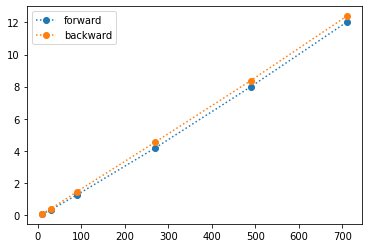

In [4]:
total_frames_to_read = [10, 30, 90, 270, 490, 710]

seek_forward_times = {}
vid.seek(0)
for nframes in total_frames_to_read: 
    frame_indices = list(range(nframes))
    with Timer() as timer:
        [vid.seek(idx) for idx in frame_indices]
        seek_forward_times[nframes] = timer.read()
    print(seek_forward_times)
        
        
seek_backward_times = {}
vid.seek(0)
for nframes in total_frames_to_read: 
    frame_indices = list(range(nframes))
    with Timer() as timer:
        [vid.seek(idx) for idx in frame_indices[::-1]]
        seek_backward_times[nframes] = timer.read()
    print(seek_backward_times)
    
    
plt.plot(seek_forward_times.keys(), seek_forward_times.values(), 'o:', label='forward')
plt.plot(seek_backward_times.keys(), seek_backward_times.values(), 'o:', label='backward')
plt.legend();

### Does seeking take up a significant proportion of reading time when only reading a single frame?

CPU times: total: 1min 8s
Wall time: 17.6 s


<BarContainer object of 5 artists>

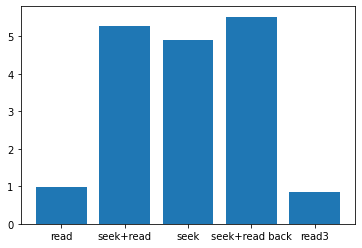

In [5]:
%%time

vid = Video('jwasp0.avi')

vid.seek(0)
with Timer() as read_only_timer:
    for idx in range(300):
        vid.read()

vid.seek(0)
with Timer() as seek_and_read_timer:
    for idx in range(300):
        vid.seek(idx)
        vid.read()
    
vid.seek(0)
with Timer() as seek_only_timer:
    for idx in range(300):
        vid.seek(idx)
        

vid.seek(0)
vals = list(range(300))[::-1]
with Timer() as seek_and_read_back_timer:
    for idx in vals:
        vid.seek(idx)
        vid.read()
    
vid.seek(0)
with Timer() as read_only_timer3:
    for idx in range(300):
        vid.read()    
    
plt.bar(
    ['read', 'seek+read', 'seek', 'seek+read back', 'read3'], 
    [read_only_timer.measured, seek_and_read_timer.measured, seek_only_timer.measured, seek_and_read_back_timer.measured, read_only_timer3.measured],
);

Answer:  Yes, Seeking is essentially all the time to read.

#### Read time Variability: How much is there?

How much of the reading variability is simply random, and how much is more related to resource allocation by the computer?

CPU times: total: 23.3 s
Wall time: 5.57 s


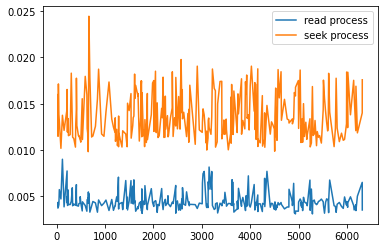

In [8]:
%%time

vid.seek(0)

frame_numbers = np.random.randint(0, len(vid), size=300) 
data = []
for frame in frame_numbers:
    vid.seek(0)
    with Timer() as timer:
        time_before_seek = timer.read()
        vid.seek(frame)
        time_after_seek = timer.read()
        vid.read()
        time_after_read = timer.read()
    seek_time = time_after_seek - time_before_seek
    read_time = time_after_read - time_after_seek
    data.append({'frame': frame, 'seekTime': seek_time, 'readTime': read_time})
    
df2 = pd.DataFrame(data).sort_values('frame')
plt.plot(df2.frame, df2.readTime, label='read process')
plt.plot(df2.frame, df2.seekTime, label='seek process')
plt.legend();

Yes, Seeking takes up an incredible amount of time!  As far as I can make out, it is also much more variable than the read time, but there doesn't seem to be a relationship between frame number and seek or read time; one can seek to any point in the video and read in frames at the same rate.

##### Cumulative effect: seeking many frames

### Memory allocation vs IO: What's taking up read times

Does it make a difference for OpenCV to preallocate arrays in memory and read them as destination?

###### Single frame case

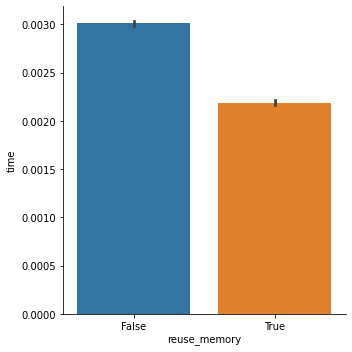

In [28]:
def run_benchmark():
    cap = cv2.VideoCapture('jwasp0.avi')
    ret, frame = cap.read()
    times = []

    with Timer() as timer:
        for _ in range(4000):
            if np.random.choice([True, False]):
                t0 = perf_counter()
                ret, _ = cap.read(frame)
                t1 = perf_counter()
                c = True
            else:
                t0 = perf_counter()
                ret, frame = cap.read()
                t1 = perf_counter()
                c = False

            times.append({'reuse_memory': c, 'time': t1 - t0})

    df = pd.DataFrame(times)
    sns.catplot(data=df, x='reuse_memory', y='time', kind='bar')
run_benchmark()

###### Multiple frames case

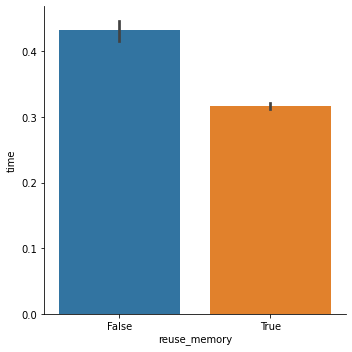

In [30]:
def run_benchmark():
    cap = cv2.VideoCapture('jwasp0.avi')
    ret, frame = cap.read()
    times = []

    with Timer() as timer:
        for _ in range(15):
            if np.random.choice([True, False]):
                
                # frames = np.empty((100,) + frame.shape, dtype=np.uint8)  # frame shape
                cap = cv2.VideoCapture('jwasp0.avi')
                t0 = perf_counter()
                frames = np.empty((100,) + frame.shape, dtype=np.uint8)  # frame shape
                for idx in range(100):
                    ret, _ = cap.read(frames[idx])
                t1 = perf_counter()
                c = True
            else:
                cap = cv2.VideoCapture('jwasp0.avi')
                t0 = perf_counter()
                frames = []
                for idx in range(100):
                    ret, frame = cap.read()
                    frames.append(frame)
                frames = np.array(frames)
                t1 = perf_counter()
                c = False

            times.append({'reuse_memory': c, 'time': t1 - t0})

    df = pd.DataFrame(times)
    sns.catplot(data=df, x='reuse_memory', y='time', kind='bar')

run_benchmark()

Takeway: yes, it makes a difference.

### Library comparison

Can we get the data faster using a different library?

In [31]:
import pims

In [32]:
%%time
vid = pims.open('jwasp0.avi')
vid

CPU times: total: 15.6 ms
Wall time: 55.6 ms


<Frames>
Format: MPEG-4 part 2
Source: jwasp0.avi
Duration: 52.708 seconds
Frame rate: 120.000 fps
Length: 6325 frames
Frame Shape: (1080, 1440, 3)

In [36]:
%%time
vid[:100]

CPU times: total: 0 ns
Wall time: 0 ns


Sliced PyAVReaderTimed. Original repr:
    <Frames>
    Format: MPEG-4 part 2
    Source: jwasp0.avi
    Duration: 52.708 seconds
    Frame rate: 120.000 fps
    Length: 6325 frames
    Frame Shape: (1080, 1440, 3)
    

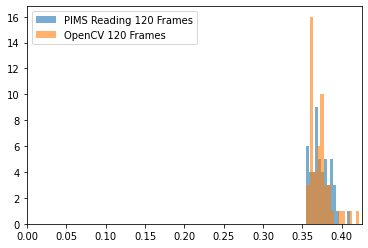

In [42]:
pims_read_times = []
for rep in range(50):
    vid = pims.open('jwasp0.avi')
    t0 = perf_counter()
    for frame in vid[:120]:
        pass
    t1 = perf_counter()
    pims_read_times.append(t1 - t0)
    
opencv_read_times = []
for rep in range(50):
    vid = cv2.VideoCapture('jwasp0.avi')
    t0 = perf_counter()
    for _ in range(120):
        ret, frame = vid.read()
    t1 = perf_counter()
    opencv_read_times.append(t1 - t0)    
    

    
plt.hist(pims_read_times, label='PIMS Reading 120 Frames', alpha=0.6, bins=15);
plt.hist(opencv_read_times, label='OpenCV 120 Frames', alpha=0.6, bins=15);
plt.xlim(0, plt.gca().get_xlim()[1])
plt.legend()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:41<00:00,  1.20it/s]


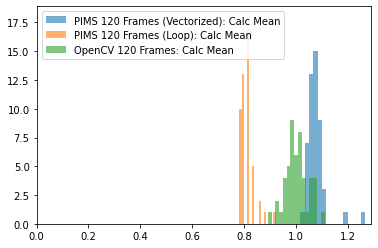

In [43]:
pims_read_times = []
for rep in tqdm(range(50)):
    vid = pims.open('jwasp0.avi')
    t0 = process_time()
    np.mean(vid[:120], axis=0)
    t1 = process_time()
    pims_read_times.append(t1 - t0)
    
pims_read_times2 = []
for rep in tqdm(range(50)):
    vid = pims.open('jwasp0.avi')
    t0 = process_time()
    for frame in vid[:120]:
        np.mean(frame)
    t1 = process_time()
    pims_read_times2.append(t1 - t0)    
    
opencv_read_times = []
for rep in tqdm(range(50)):
    vid = cv2.VideoCapture('jwasp0.avi')
    t0 = process_time()
    for _ in range(120):
        ret, frame = vid.read()
        np.mean(frame)
    t1 = process_time()
    opencv_read_times.append(t1 - t0)    
    

    
plt.hist(pims_read_times, label='PIMS 120 Frames (Vectorized): Calc Mean', alpha=0.6, bins=15);
plt.hist(pims_read_times2, label='PIMS 120 Frames (Loop): Calc Mean', alpha=0.6, bins=15);
plt.hist(opencv_read_times, label='OpenCV 120 Frames: Calc Mean', alpha=0.6, bins=15);
plt.xlim(0, plt.gca().get_xlim()[1])
plt.legend()

In [44]:
print(pims.open('jwasp0.avi'))
print(f"{getsize('jwasp0.avi') / 1024 ** 2 : .2f} MB", end="\n\n\n")

print(pims.open('jwasp0b.avi'))
print(f"{getsize('jwasp0b.avi') / 1024 ** 2 : .2f} MB", end="\n\n\n")

<Frames>
Format: MPEG-4 part 2
Source: jwasp0.avi
Duration: 52.708 seconds
Frame rate: 120.000 fps
Length: 6325 frames
Frame Shape: (1080, 1440, 3)

 123.68 MB


<Frames>
Format: H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
Source: jwasp0b.avi
Duration: 52.708 seconds
Frame rate: 120.000 fps
Length: 6325 frames
Frame Shape: (1080, 1440, 3)

 1.48 MB




CPU times: total: 4min 50s
Wall time: 4min 50s


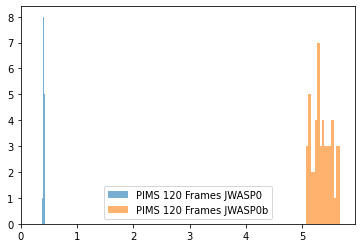

In [49]:
%%time

pims_read_times = []
for rep in range(50):
    vid = pims.open('jwasp0.avi')
    t0 = perf_counter()
    for frame in vid[:120]:
        pass
    t1 = perf_counter()
    pims_read_times.append(t1 - t0)
    
pims_read_times2 = []
for rep in range(50):
    vid = pims.open('jwasp0b.avi')
    t0 = perf_counter()
    for frame in vid[:120]:
        pass
    t1 = perf_counter()
    pims_read_times2.append(t1 - t0)    
    
plt.hist(pims_read_times, label='PIMS 120 Frames JWASP0', alpha=0.6, bins=15);
plt.hist(pims_read_times2, label='PIMS 120 Frames JWASP0b', alpha=0.6, bins=15);
plt.xlim(0, plt.gca().get_xlim()[1])
plt.legend()    

This is a massive difference in read time between the two formats:
    - **0.25** seconds for 120 frames for the **MPEG-4 part 2 AVI** File
    - **3.25** seconds for 120 frames for the **H.264 AVI** File

CPU times: total: 56.8 s
Wall time: 38.6 s


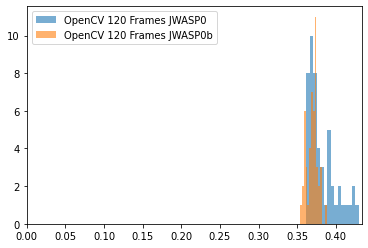

In [50]:
%%time

opencv_read_times = []
for rep in range(50):
    vid = cv2.VideoCapture('jwasp0.avi')
    t0 = perf_counter()
    for _ in range(120):
        ret, frame = vid.read()
    t1 = perf_counter()
    opencv_read_times.append(t1 - t0)   
    
opencv_read_times2 = []
for rep in range(50):
    vid = cv2.VideoCapture('jwasp0b.avi')
    t0 = perf_counter()
    for _ in range(120):
        ret, frame = vid.read()
    t1 = perf_counter()
    opencv_read_times2.append(t1 - t0)     
    
plt.hist(opencv_read_times, label='OpenCV 120 Frames JWASP0', alpha=0.6, bins=15);
plt.hist(opencv_read_times2, label='OpenCV 120 Frames JWASP0b', alpha=0.6, bins=15);
plt.xlim(0, plt.gca().get_xlim()[1])
plt.legend()    

OpenCV, on the other hand, isn't having any difference between the two file formats.  It is slower than the best case,
but much, much faster than the worst case for PIMS with x264

In [51]:
frame_mb = np.empty_like(frame).nbytes / 1024 ** 2
f"For a {frame_mb:.1f}MB frame, 2GB of Memory can hold roughly {2048 / frame_mb:.0f} Frames ({2048 / frame_mb / 120: .2} secs for 120 fps )."

'For a 4.4MB frame, 2GB of Memory can hold roughly 460 Frames ( 3.8 secs for 120 fps ).'

### Processing Time for common operations

In [52]:
%%time

vid = cv2.VideoCapture('jwasp0b.avi')
_, frame = vid.read()

# %timeit np.mean(frame)
functions = [vid.read, np.mean, np.median, np.max, np.min, np.std,]

for fun in functions:
    print(fun.__name__, 'on 120 frames...')
    %timeit x = [fun(frame) for rep in range(120)]
    print('')
    



read on 120 frames...
239 ms ± 8.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

mean on 120 frames...
421 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

median on 120 frames...
789 ms ± 8.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

amax on 120 frames...
506 ms ± 8.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

amin on 120 frames...
388 ms ± 7.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

std on 120 frames...
2.89 s ± 40.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

CPU times: total: 43.3 s
Wall time: 42 s
